# Introduction

Compare how the 10x minimal annotation experiments performed. (It's mostly protein, linc, and antisense genes left

In [1]:
import numpy
import scanpy
import anndata
import os
import pandas
from matplotlib import pyplot
from matplotlib import cm
import scipy
from pathlib import Path
import upsetplot
import louvain
import sklearn
import seaborn
import logging

from pipeline_common import get_gene_id_to_name, load_gtf
from common import (
    scanpy_load_kallisto_gene_mtx,
    scanpy_load_alevin_mtx,
)
#from cuml.decomposition import PCA
#from cuml.manifold import TSNE


In [2]:
analysis_dir = Path('ENCSR874BOF_e10_5_minimal_limb')

In [3]:
ls $analysis_dir/*.h5ad

ENCSR874BOF_e10_5_minimal_limb/alevin_decoy.h5ad
ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad
ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad
ENCSR874BOF_e10_5_minimal_limb/kallisto_em_filtered.h5ad
ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad
ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad


In [4]:
cellranger_name = "Cell Ranger"
star_name = "STAR Solo"
alevin_name = "Salmon Alevin (EM)"
alevin_decoy_name = "Salmon Alevin Decoy (EM)"
kallisto_name = "Kallisto"
kallisto_em_name = "Kallisto (EM)"

In [5]:
tenx_datasets = {
    cellranger_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad').to_df().T,
    star_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad').to_df().T,
    alevin_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad').to_df().T,
    alevin_decoy_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin_decoy.h5ad').to_df().T,    
    kallisto_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad').to_df().T,
    kallisto_em_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_em_filtered.h5ad').to_df().T,
}

## Compute Spearman functions

In [6]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


In [7]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    obs_names = left.obs_names
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.X.todense()
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.X.todense()

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for i in range(left.shape[0]):
        cors.append(scipy.stats.spearmanr(left[:,i], right[:,i])[0])
    cors = pandas.Series(cors, index=obs_names)
    #[~numpy.isnan(cors)]
    return cors


In [8]:
cr = compute_spearman_pandas(tenx_datasets[cellranger_name], tenx_datasets[star_name])
print('raw', len(cr))
print('filtered', len(cr[~numpy.isnan(cr)]))

raw 6289
filtered 6289


In [9]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [10]:
tenx_cors = compute_correlations(tenx_datasets)

In [11]:
tenx_cors[cellranger_name][star_name].shape

(6289,)

In [12]:
def compute_pearson_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.pearsonr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_pearson_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_pearson_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [13]:
tenx_pearson = compute_pearson_correlations(tenx_datasets)

In [14]:
tenx_pearson[cellranger_name][star_name].shape

(6289,)

In [15]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)


def plot_cell_correlation_histogram(
    table, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    override_labels = {
        'Alevin': 'Salmon Alevin (EM)',
        'Kallisto EM': 'Kallisto Bus (EM)'
    }
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    #f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    
    for i in range(0, plot_size):
        for j in range(i+1, plot_size):
            set_all_spines(axes[i, j], False)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            x_label = override_labels.get(name_x, name_x)
            y_label = override_labels.get(name_y, name_y)
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if xlim is not None:
                ax.set_xlim(xlim)
            #set_all_spines(ax, True)
            if x == 0:
                ax.set_ylabel(y_label, fontname=fontname, fontsize=fontsize)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            nantext=""
            if count_nans:
                nantext="\nNaNs {}".format(table[name_x][name_y].isna().sum())
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
            #ax.annotate(f'Mean {mean}\nMedian {median}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    for y in range(plot_size):
        x_label = override_labels.get(programs[y], programs[y])
        axes[0, y].set_title(x_label, fontname=fontname, fontsize=fontsize)
        axes[plot_size-1, y].set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    #f.tight_layout()
    return f

# 10x minimal correlation histograms

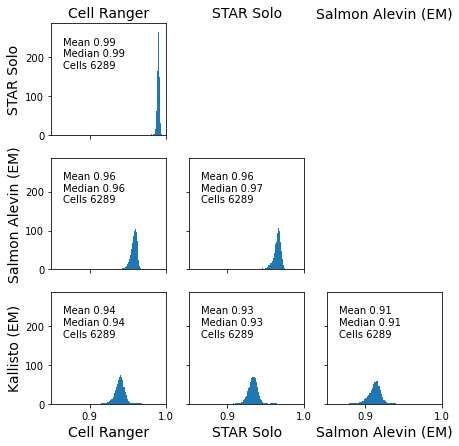

In [16]:
#plot_cell_correlation_histogram(tenx_cors, programs=['Cell Ranger', 'STAR Solo', 'Alevin', 'Kallisto EM'])
f = plot_cell_correlation_histogram(tenx_cors, programs=[cellranger_name, star_name, alevin_name, kallisto_em_name], xlim=(0.85,1.0))
#f.suptitle("10x mouse limb e10.5 per-cell Spearman", fontsize=16)
#f.suptitle("10x mouse limb e10.5 per-cell Spearman", fontsize=16)
pass

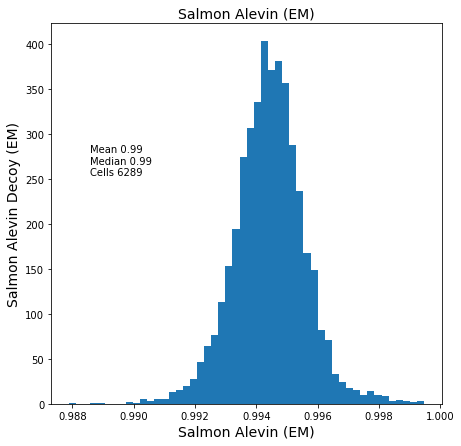

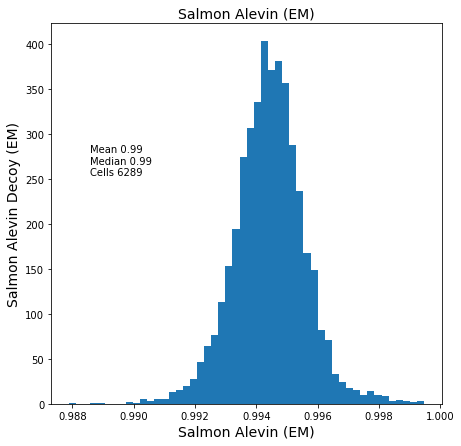

In [17]:
plot_cell_correlation_histogram(tenx_cors, programs=[alevin_name, alevin_decoy_name])

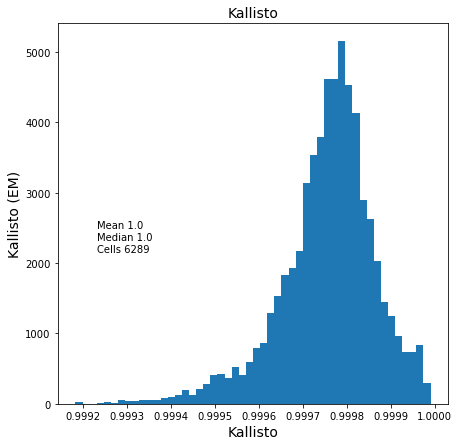

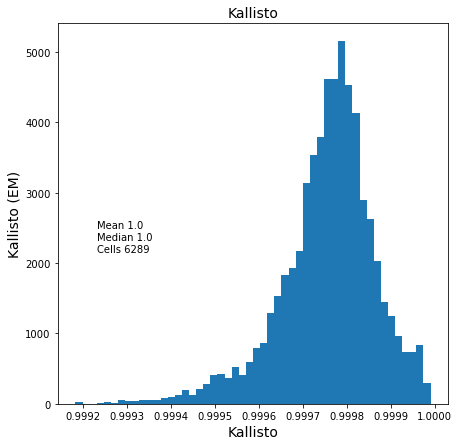

In [18]:
plot_cell_correlation_histogram(tenx_cors, programs=[kallisto_name, kallisto_em_name], y_annot=.4)

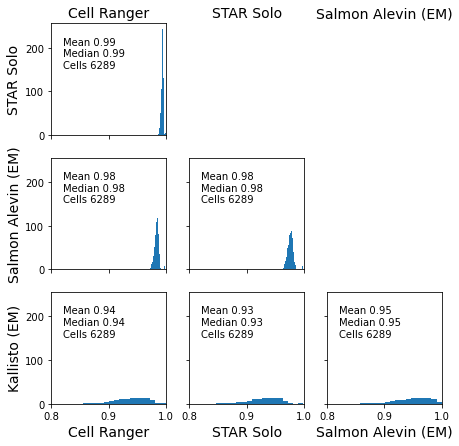

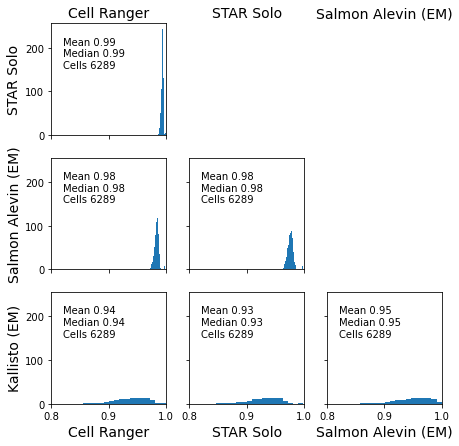

In [19]:
plot_cell_correlation_histogram(tenx_pearson, programs=[cellranger_name, star_name, alevin_name, kallisto_em_name], correlation_name='Pearson',xlim=(0.8,1.0))

In [20]:
numpy.asarray(cm.get_cmap("Set1").colors[0] )*255

array([228.,  26.,  28.])

def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    #ax.plot([-5,10], [-5,10], c=set1[2])
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    ax.scatter(table[name_x][cell_id]+0.01, table[name_y][cell_id]+0.01, color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    count = numpy.sum((table[name_x][cell_id] > 0) & (table[name_y][cell_id] > 0))
    ax.set_title(f'id {cell_id}\n{spearman:0.4}\nGenes: {count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(name_x, fontsize=fontsize, fontfamily=fontname)
    ax.set_ylabel(name_y, fontsize=fontsize, fontfamily=fontname)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


In [21]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, threshold=0.8, ax=None):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    left = table[name_x][cell_id].to_frame()
    right = table[name_y][cell_id].to_frame()
    left_name = cell_id + "_x"
    right_name = cell_id + "_y"    
    counts = left.merge(right, left_index=True, right_index=True, how='inner')
    
    rel_diff = numpy.abs(counts[left_name]-counts[right_name])/(counts.max(axis=1)+1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[x] for x in (rel_diff > threshold).values]
    
    #counts.plot.scatter(x=cell_id+"_x", y=cell_id+"_y", ax=ax, s=2)
    ax.scatter(counts[left_name], counts[right_name], c=colors, s=2)
    #b = 6
    lim = numpy.arange(0.1, counts.max().max(), 0.1)
    #lim_up = lim + b
    #lim_down = lim -b
    ax.plot(lim, lim, c=set1[2], alpha=0.5)
    #ax.plot(lim, lim_up, c=set1[0], alpha=0.5)
    #ax.plot(lim, lim_down, c=set1[0])
    ax.set_xlim((.1, counts.max().max()))
    ax.set_ylim((.1, counts.max().max()))
    #ax.scatter(table[name_x][cell_id].X.todense()+0.01, table[name_y][cell_id].X.todense()+0.01, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    gene_count = counts[counts > 0].count().max()
    ax.set_title(f'id {cell_id}\n{spearman:0.4}\nGenes: {gene_count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(name_x, fontsize=fontsize, fontfamily=fontname)
    ax.set_ylabel(name_y, fontsize=fontsize, fontfamily=fontname)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

    
def show_scatter_cells(dense_mat, correlations, name_x, name_y, cells, threshold=0.8):
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1, len(cells), sharex=True, sharey=True)
    for ax, cell in zip(axes, cells):
        sc_scatter(dense_mat, correlations, name_x, name_y, cell, threshold=threshold, ax=ax)
    return f    

def show_scatter_extremes(dense_mat, correlations, name_x, name_y, threshold=0.8):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    #print(best_cell, worst_cell, median_cell)
    cells = [worst_cell, median_cell, best_cell]
    show_scatter_cells(dense_mat, correlations, name_x, name_y, cells, threshold)


def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    #print(best_cell, worst_cell, median_cell)
    cells = [worst_cell, median_cell, best_cell]
    show_scatter_cells(dense_mat, correlations, name_x, name_y, cells)
    
def show_scatter_cells(dense_mat, correlations, name_x, name_y, cells):
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1, len(cells), sharex=True, sharey=True)
    for ax, cell in zip(axes, cells):
        sc_scatter(dense_mat, correlations, name_x, name_y, cell, ax=ax)
    return f
    

Show scatter plots of two algorithms on the same cell, I chose the worst, median, and best spearman correlations. The header is cell ID, spearmen correlation, and how many gtf annotations are shown on the plot. Points colored red are the ERCC spike ins

## 10x minimal cellranger vs star solo

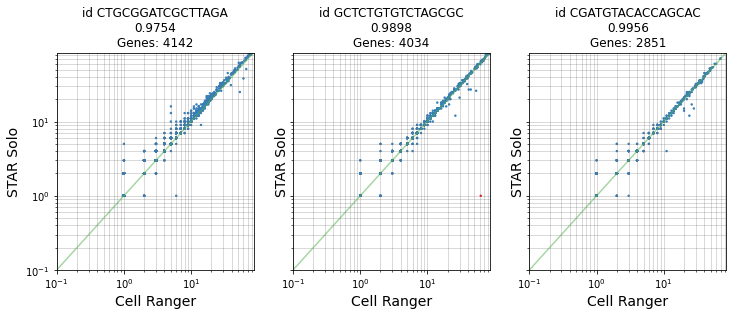

In [22]:
show_scatter_extremes(tenx_datasets, tenx_cors, cellranger_name, star_name)


In [23]:
cells = ['CTGCGGATCGCTTAGA', 'GCTCTGTGTCTAGCGC', 'CGATGTACACCAGCAC']

## 10x minimal cellranger vs alevin

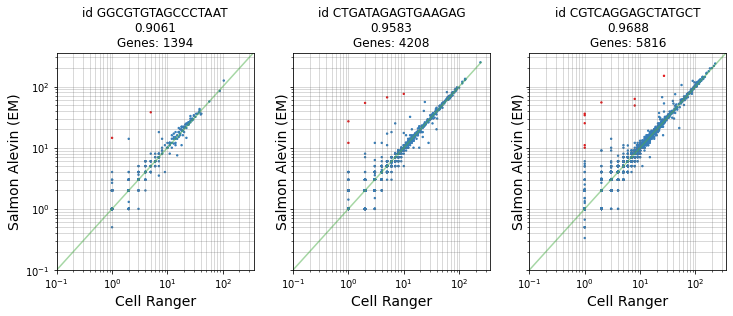

In [24]:
show_scatter_extremes(tenx_datasets, tenx_cors, cellranger_name, alevin_name)

## 10x minimal cellranger vs kallisto

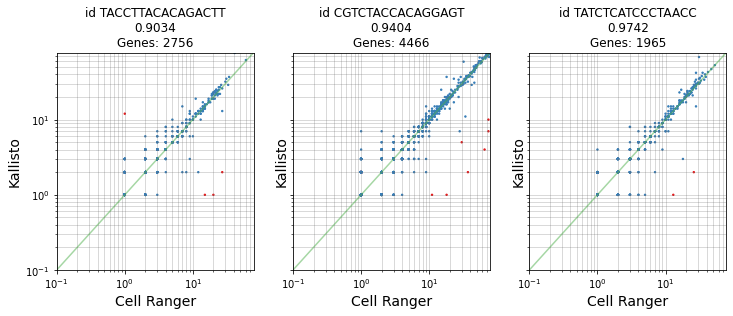

In [25]:
show_scatter_extremes(tenx_datasets, tenx_cors, cellranger_name, kallisto_name)

## 10x minimal star solo vs alevin

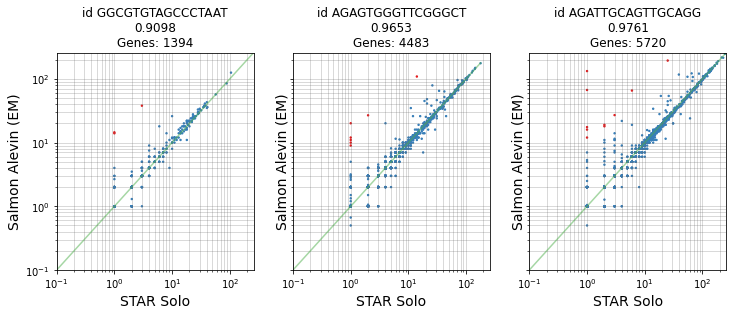

In [27]:
show_scatter_extremes(tenx_datasets, tenx_cors, star_name, alevin_name)

## 10x minimal star solo vs kallisto

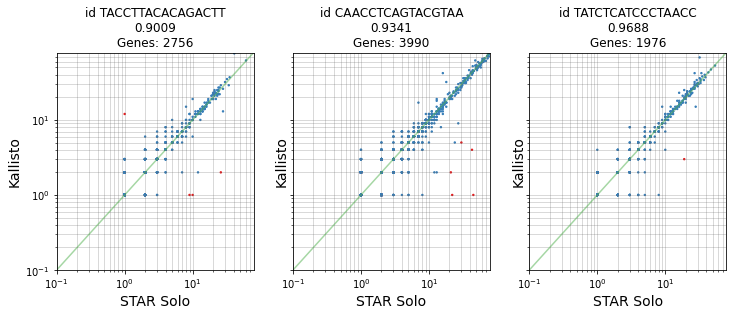

In [28]:
show_scatter_extremes(tenx_datasets, tenx_cors, star_name, kallisto_name)

## 10x minimal alevin vs kallisto

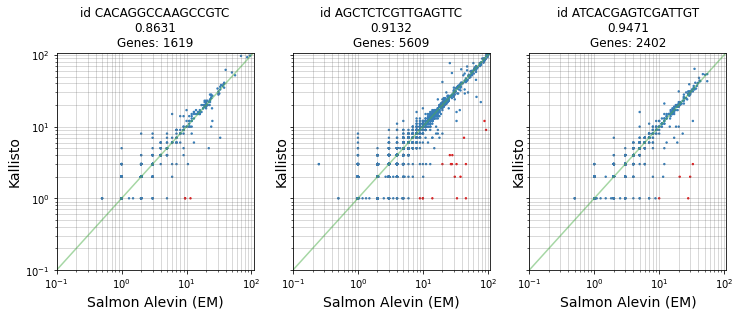

In [29]:
show_scatter_extremes(tenx_datasets, tenx_cors, alevin_name, kallisto_name)

In [30]:
## 10x minimal alevin vs alevin_decoy

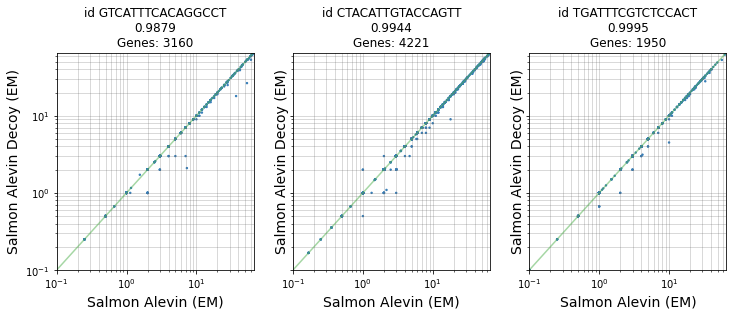

In [31]:
show_scatter_extremes(tenx_datasets, tenx_cors, alevin_name, alevin_decoy_name)

In [32]:
## 10x minimal kallisto vs kallisto_em

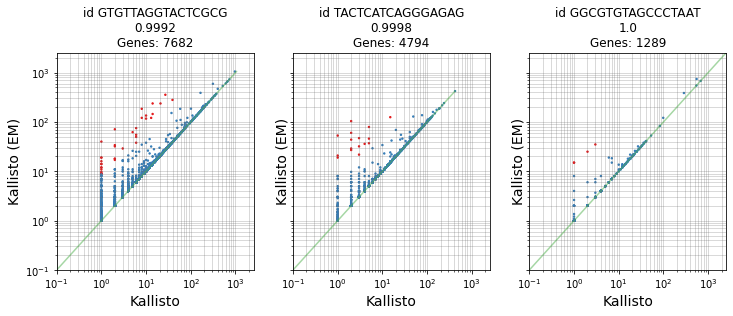

In [33]:
show_scatter_extremes(tenx_datasets, tenx_cors, kallisto_name, kallisto_em_name)

In [34]:
diff = (tenx_datasets[kallisto_em_name]['GGCGTGTAGCCCTAAT'] - tenx_datasets[kallisto_name]['GGCGTGTAGCCCTAAT'])
diff[diff > 0].sort_values()

ENSMUSG00000043091.9       0.071450
ENSMUSG00000003134.10      0.090910
ENSMUSG00000060143.7       0.210530
ENSMUSG00000045690.8       0.363640
ENSMUSG00000052305.6       0.676470
ENSMUSG00000073702.11      0.909100
ENSMUSG00000040385.7       1.000000
ENSMUSG00000008668.15      1.000000
ENSMUSG00000046516.10      1.000000
ENSMUSG00000021377.15      1.000000
ENSMUSG00000058546.8       1.000000
ENSMUSG00000009927.9       1.000000
ENSMUSG00000030965.19      1.000000
ENSMUSG00000032383.7       1.000000
ENSMUSG00000073676.4       1.000000
ENSMUSG00000035437.15      1.000000
ENSMUSG00000027959.14      1.000000
ENSMUSG00000037894.13      1.000000
ENSMUSG00000038722.17      1.000000
ENSMUSG00000058174.7       1.625000
ENSMUSG00000023004.8       1.928500
ENSMUSG00000050708.16      2.000000
ENSMUSG00000035530.13      2.000000
ENSMUSG00000049751.6       3.000000
ENSMUSG00000034120.18      3.000000
ENSMUSG00000041453.12      3.000000
ENSMUSG00000025508.13      3.636400
ENSMUSG00000093674.7       3

In [35]:
diff = (tenx_datasets[kallisto_em_name]['TACTCATCAGGGAGAG'] - tenx_datasets[kallisto_name]['TACTCATCAGGGAGAG'])
diff[diff > 0].sort_values()

ENSMUSG00000053291.15      0.004760
ENSMUSG00000033446.7       0.004760
ENSMUSG00000040651.9       0.004760
ENSMUSG00000030286.6       0.004760
ENSMUSG00000035762.11      0.004760
                            ...    
ENSMUSG00000079523.8      60.000000
ENSMUSG00000061983.7      74.000000
ENSMUSG00000049517.8      79.807007
ENSMUSG00000008682.13    102.000000
ENSMUSG00000074129.14    110.000000
Name: TACTCATCAGGGAGAG, Length: 387, dtype: float32

In [36]:
tenx_datasets[kallisto_name]['TACTCATCAGGGAGAG'].sort_values().tail()

ENSMUSG00000067274.10    189.0
ENSMUSG00000044533.15    190.0
ENSMUSG00000026238.14    217.0
ENSMUSG00000029580.14    239.0
ENSMUSG00000097971.3     422.0
Name: TACTCATCAGGGAGAG, dtype: float32

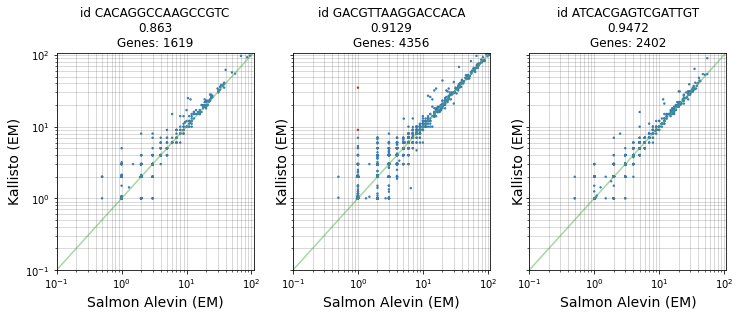

In [37]:
show_scatter_extremes(tenx_datasets, tenx_cors, alevin_name, kallisto_em_name)

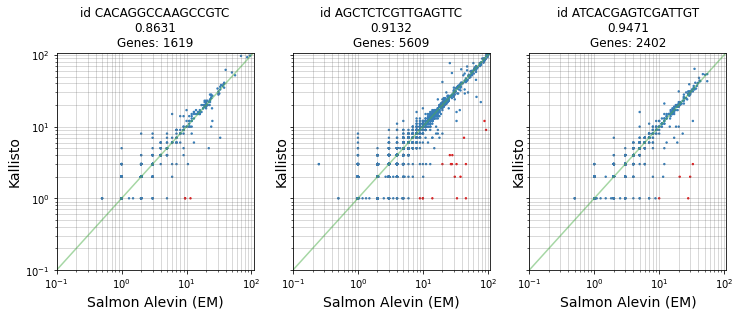

In [38]:
show_scatter_extremes(tenx_datasets, tenx_cors, alevin_name, kallisto_name)

# Again with the same set of cells

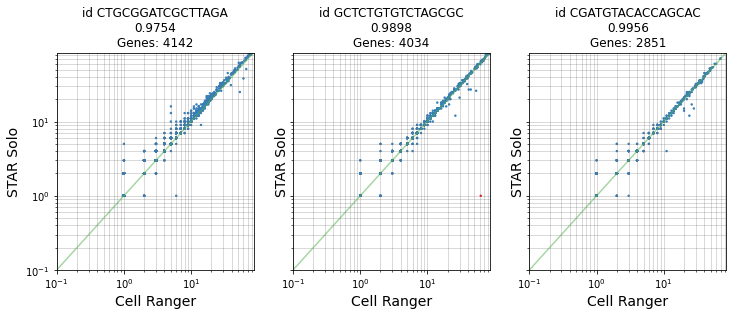

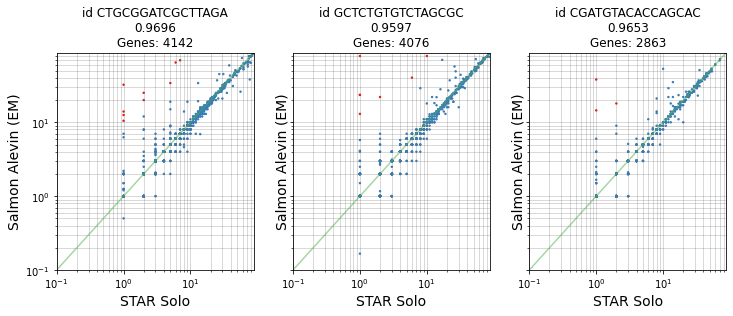

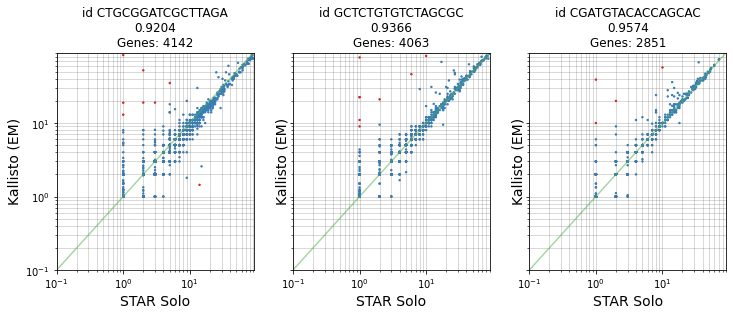

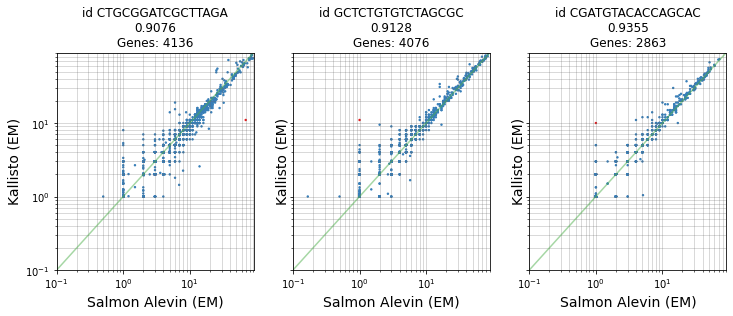

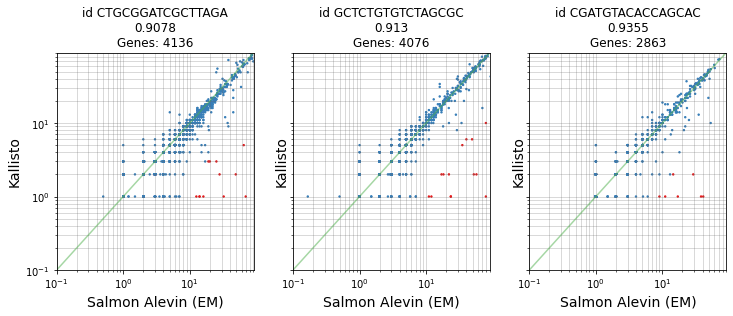

In [39]:
for name_x, name_y in [(cellranger_name, star_name), (star_name, alevin_name), 
                       (star_name, kallisto_em_name), (alevin_name, kallisto_em_name),
                       (alevin_name, kallisto_name)
                      ]:
    f = show_scatter_cells(tenx_datasets, tenx_cors, name_x, name_y, cells)

## Look at genes that are zero in one algorithm but expressed in the other

In [40]:
store = pandas.HDFStore(Path('~/proj/genome/mm10-M21-male/mm10-M21-male.h5').expanduser())
gtf = store[store.keys()[0]]
store.close()


In [41]:
def find_border_cells(table, left_name, right_name, cell_id, threshold=0):
    _left_name = "_" + left_name
    _right_name = "_" + right_name
    cells = pandas.merge(
        tenx_datasets[left_name][cell_id], tenx_datasets[right_name][cell_id],
        left_index=True, right_index=True, suffixes=(_left_name, _right_name))
    left_edge = (cells[cell_id+_left_name] == 0) & (cells[cell_id+_right_name] > threshold)
    return cells[left_edge].sort_values(by=cell_id+_right_name, ascending=False)

In [42]:
#cell_id = 'ATCACGAGTCGATTGT'
cell_id = 'AGCTCTCGTTGAGTTC'
border_cells = find_border_cells(tenx_datasets, kallisto_name, alevin_name, cell_id)

In [43]:
alevin_expressed = find_border_cells(tenx_datasets, kallisto_name, alevin_name, cell_id, 0).merge(gtf[gtf['type'] == 'gene'][['gene_id', 'gene_name']], left_index=True, right_on="gene_id", how="left")
alevin_expressed.to_csv("alevin_expressed_kallisto_"+cell_id+'.csv')
alevin_expressed

,AGCTCTCGTTGAGTTC_Kallisto,AGCTCTCGTTGAGTTC_Salmon Alevin (EM),gene_id,gene_name
1337450,0.0,28.461561,ENSMUSG00000094248.1,Hist1h2ao
1042244,0.0,16.000000,ENSMUSG00000050621.7,Rps27rt
270087,0.0,12.000000,ENSMUSG00000027637.3,Rab5if
1534066,0.0,11.000000,ENSMUSG00000056851.14,Pcbp2
1046388,0.0,10.000000,ENSMUSG00000006932.17,Ctnnb1
...,...,...,...,...
285913,0.0,0.090909,ENSMUSG00000095199.7,Zfp967
285839,0.0,0.090909,ENSMUSG00000089951.8,Gm14435
978196,0.0,0.009892,ENSMUSG00000058443.5,Rpl10-ps3
1337722,0.0,0.001768,ENSMUSG00000069302.5,Hist1h2ah


In [44]:
kallisto_em_cells = find_border_cells(tenx_datasets, alevin_name, kallisto_em_name, cell_id, 0).merge(gtf[gtf['type'] == 'gene'][['gene_id', 'gene_name']], left_index=True, right_on="gene_id", how="left")
kallisto_em_cells.columns = ["Alevin", "Kallisto", "gene_id", "gene_name"]
alevin_cells = find_border_cells(tenx_datasets, kallisto_em_name, alevin_name, cell_id, 0).merge(gtf[gtf['type'] == 'gene'][['gene_id', 'gene_name']], left_index=True, right_on="gene_id", how="left")
alevin_cells.columns = ["Kallisto", "Alevin", "gene_id", "gene_name"]
book = pandas.ExcelWriter("kallisto_em_alevin_differential.xlsx")
korder = ["gene_id", "gene_name", "Kallisto", "Alevin"]
kallisto_em_cells[korder].to_excel(book, "kallisto_em_expressed_alevin_0 "+cell_id, index=False)
aorder = ["gene_id", "gene_name", "Alevin", "Kallisto"]
alevin_cells[aorder].to_excel(book, "alevin_expressed_kallisto_em_0 "+cell_id, index=False)
book.close()

InvalidWorksheetName: Excel worksheet name 'kallisto_em_expressed_alevin_0 AGCTCTCGTTGAGTTC' must be <= 31 chars.

In [ ]:
kallisto_em_cells.head()

In [ ]:
alevin_cells.head()

In [ ]:
cellranger_raw = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-minimal-e10_5-count-cells10000/outs/raw_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_raw.obs_names = [x[:-2] for x in cellranger_raw.obs_names]
cellranger_raw.obs['counts'] = cellranger_raw.X.sum(axis=1)
cellranger_raw.obs['ngenes'] = numpy.array((cellranger_raw.X > 0).sum(axis=1))

cellranger_raw.shape

In [ ]:
kallisto_em_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto_em' / 'genecount')
print('Kallisto_em_raw shape', kallisto_em_raw.shape)


In [ ]:
alevin = scanpy_load_alevin_mtx(
    analysis_dir / 'alevin',
    force_var_names=cellranger_raw.var_names,
)
alevin.shape

In [ ]:
f = pyplot.figure(figsize=(10,6))
ax = f.add_subplot(1,1,1)

alpha = 0.8
gridalpha = 0.5
fontsize = 12
#max_barcodes = max(cellranger_raw.X.shape[0], solo_raw.X.shape[0], kallisto_raw.X.shape[0], alevin_decoy.X.shape[0], alevin.X.shape[0])
#tenx_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0])

ax.set_title('Knee plot for most unfiltered matrix returned by algorithms')
cellranger_ranked_umi = numpy.sort(numpy.array(cellranger_raw.obs['counts']), axis=None)[::-1]
ax.plot(cellranger_ranked_umi, range(cellranger_ranked_umi.shape[0]), linewidth=2, alpha=alpha, 
        #c=colors['cell ranger'],
        label='Cell Ranger')

kallisto_em_ranked_umi = numpy.sort(numpy.array(kallisto_em_raw.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_em_ranked_umi,  range(kallisto_em_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        #c=colors['kallisto_em'],
        label='Kallisto (EM)')

alevin_ranked_umi = numpy.sort(numpy.array(alevin.obs['counts']), axis=None)[::-1]
ax.plot(alevin_ranked_umi, range(alevin_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        #c=colors['alevin'],
        label='Alevin (EM)')

ax.set_xlabel('Cumulative number of barcodes', fontsize=fontsize)
ax.set_ylabel('count of reported UMIs', fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e5)
ax.set_ylim(1,1e6)
ax.grid(
    color="dimgrey", linestyle="-", linewidth=0.5, which="both", alpha=gridalpha
)

ax.legend()
pass

# Compare C1 minimal

In [ ]:
c1_pseudo = Path('c1_pseudo')

In [ ]:
rsem_c1_name = "RSEM (EM)"
star_c1_name = "STAR"
kallisto_c1_name = "Kallisto insert (EM)"
kallisto_f100_c1_name = "Kallisto (EM)"
salmon_c1_name = "Salmon (EM)"
c1_gene_counts = {
    rsem_c1_name: scanpy.read_h5ad(c1_pseudo / "rsem_gene_counts.h5ad").to_df().fillna(0).T,
    star_c1_name: scanpy.read_h5ad(c1_pseudo / 'star_minimal_gene_counts.h5ad').to_df().fillna(0).T,
    kallisto_c1_name: scanpy.read_h5ad(c1_pseudo / 'kallisto_minimal_gene_counts.h5ad').to_df().fillna(0).T,
    kallisto_f100_c1_name: scanpy.read_h5ad(c1_pseudo / 'kallisto_minimal_f100_gene_est_counts.h5ad').to_df().fillna(0).T,
    salmon_c1_name: scanpy.read_h5ad(c1_pseudo / 'salmon_minimal_gene_counts.h5ad').to_df().fillna(0).T,
    #salmon_decoy_c1_name: scanpy.read_h5ad(c1_pseudo / 'salmon_decoy_minimal_gene_counts.h5ad').to_df().fillna(0).T,
}

In [ ]:
c1_gene_count_cors = compute_correlations(c1_gene_counts)

## C1 spearman correlation histogram

In [ ]:
f = plot_cell_correlation_histogram(c1_gene_count_cors)

Show scatter plots of two algorithms on the same cell, I chose the worst, median, and best spearman correlations. The header is cell ID, spearmen correlation, and how many gtf annotations are shown on the plot. Points colored red are the ERCC spike ins

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, rsem_c1_name, star_c1_name)

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, rsem_c1_name, kallisto_c1_name)

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, rsem_c1_name, kallisto_c1_name)

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, rsem_c1_name, kallisto_f100_c1_name)

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, rsem_c1_name, salmon_c1_name)

## C1 star minimal vs kallisto minimal

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, star_c1_name, kallisto_c1_name)

# C1 STAR minimal vs kallisto fragment size 100

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, star_c1_name, kallisto_f100_c1_name)

## C1 minimal star vs alevin

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, star_c1_name, salmon_c1_name)

## C1 star kallisto vs alevin

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, kallisto_c1_name, salmon_c1_name)

# C1 kallisto vs kallisto f100

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, kallisto_c1_name, kallisto_f100_c1_name)

In [ ]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_cors, kallisto_f100_c1_name, salmon_c1_name)

In [ ]:
def sc_scatter_for_pptx(table, correlations, name_x, name_y, cell_id, ax=None):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    ax.scatter(table[name_x][cell_id]+0.01, table[name_y][cell_id]+0.01, color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    count = numpy.sum((table[name_x][cell_id] > 0) & (table[name_y][cell_id] > 0))
    ax.set_title(f'Spearman {spearman:0.4}\nGene count: {count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(name_x, fontsize=fontsize, fontfamily=fontname)
    ax.set_ylabel(name_y, fontsize=fontsize, fontfamily=fontname)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


In [ ]:
"19917_D8", "20046_C7", "18255_E2", 

In [ ]:
f = pyplot.figure(figsize=(10,4))
axes = f.subplots(1, 3, sharex=True, sharey=True)
sc_scatter_for_pptx(c1_gene_counts, c1_gene_count_cors, kallisto_f100_c1_name, salmon_c1_name, "20046_C7", ax=axes[0])
sc_scatter_for_pptx(c1_gene_counts, c1_gene_count_cors, star_c1_name, kallisto_f100_c1_name, "20046_C7", ax=axes[1])
sc_scatter_for_pptx(c1_gene_counts, c1_gene_count_cors, star_c1_name, salmon_c1_name, "20046_C7", ax=axes[2])
f.tight_layout()

In [ ]:
spike = c1_gene_counts['kallisto_minimal'].tail(97)

In [ ]:
spike.sum().sort_values()

In [ ]:
spike_18087_F8 = c1_gene_counts['kallisto_minimal']['18087_F8'].tail(97)

In [ ]:
spike_18087_F8[spike_18087_F8 > 0]

In [ ]:
spike_gene_counts = {}
for key in c1_gene_counts:
    spike_gene_counts[key] = c1_gene_counts[key].tail(97)

spike_gene_cors = compute_correlations(spike_gene_counts)

In [ ]:

show_scatter_extremes(spike_gene_counts, spike_gene_cors, rsem_c1_name, kallisto_f100_c1_name)

In [ ]:
plot_cell_correlation_histogram(spike_gene_cors, bins=5, programs=['RSEM (EM)', "Kallisto 100 (EM)", "Alevin (EM)"],
                                xlim=(0.96, 1.0))